In [2]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
target = pd.read_csv('data/SampleSubmissionStage1.csv').set_index('ID').drop('Pred', axis=1)
target['Season'] = target.index.map(lambda i: i[:4])
target['team_a'] = target.index.map(lambda i: i[5:9])
target['team_b'] = target.index.map(lambda i: i[10:14])
target['in_target'] = True
target.sample()

,Season,team_a,team_b,in_target
ID,,,,
2014_1326_1409,2014,1326,1409,True


In [4]:
ncaa_games = pd.read_csv('data/NCAATourneyCompactResults.csv')
ncaa_games = ncaa_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
ncaa_games['diff'] = ncaa_games['WScore'] - ncaa_games['LScore']
print(ncaa_games.shape)
ncaa_games.sample()

(2117, 9)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff
1349,2006,137,1206,75,1277,65,N,0,10


In [5]:
regular_games = pd.read_csv('data/RegularSeasonCompactResults.csv')
regular_games = regular_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
regular_games['diff'] = regular_games['WScore'] - regular_games['LScore']
print(regular_games.shape)
regular_games.sample()

(150684, 9)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff
104361,2009,45,1445,66,1300,51,A,0,15


In [214]:
data = cp.deepcopy(ncaa_games)
data['team_a'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) < int(t[1]) else t[1], axis=1)
data['team_b'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) > int(t[1]) else t[1], axis=1)
data['a_win'] = data['WTeamID'] == data['team_a']
data = data[['Season', 'team_a', 'team_b', 'a_win']]
data = pd.concat([data, target.reset_index(drop=True)]).fillna(0).astype({'a_win': bool, 'in_target': bool})

lags = 5
for team, opponent_team in [('a', 'b'), ('b','a')]:
    
    
    # GAMES WON IN PAST TOURNAMENTS
    won_in_ncaa = ncaa_games\
        .groupby(['WTeamID', 'Season']).count()[['diff']]\
        .rename(columns={'diff': 'won_in_ncaa_{}'.format(team)})
    for l in range(1, lags+1):
        won_in_ncaa[
            'won_in_ncaa_{}_lag-{}'.format(team, l)] = won_in_ncaa.groupby('WTeamID')[
            'won_in_ncaa_{}'.format(team)
        ].shift(l).fillna(0)
    won_in_ncaa.drop('won_in_ncaa_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, won_in_ncaa,
                    left_on=['team_{}'.format(team), 'Season'], right_index=True,
                    how='left').fillna(0)
    
    # GAMES WON IN PAST SEASONS
    won_in_season = regular_games\
        .groupby(['WTeamID', 'Season']).count()[['diff']]\
        .rename(columns={'diff': 'won_in_season_{}'.format(team)})
    for l in range(0, lags+1):
        won_in_season[
            'won_in_season_{}_lag-{}'.format(team, l)] = won_in_season.groupby('WTeamID')[
            'won_in_season_{}'.format(team)
        ].shift(l).fillna(0)
    won_in_season.drop('won_in_season_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, won_in_season,
                    left_on=['team_{}'.format(team), 'Season'], right_index=True,
                    how='left').fillna(0)
    
    
    # TOURNAMENT GAMES WON AGAINST OPPONENT
    ncaa_wins_against_opponent = ncaa_games\
        .groupby(['Season', 'WTeamID', 'LTeamID']).count()[['diff']]\
        .rename(columns={'diff': 'ncaa_wins_against_opponent_{}'.format(team)})
    for l in range(1, lags+1):
        ncaa_wins_against_opponent[
            'ncaa_wins_against_opponent_{}_lag-{}'.format(team, l)
        ] = ncaa_wins_against_opponent.groupby(['WTeamID', 'LTeamID'])\
            ['ncaa_wins_against_opponent_{}'.format(team)].shift(l)
    ncaa_wins_against_opponent.drop('ncaa_wins_against_opponent_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, ncaa_wins_against_opponent,
                    left_on=['Season', 'team_{}'.format(team), 'team_{}'.format(opponent_team)],
                    right_index=True,
                    how='left').fillna(0)
    
    
    # SEASON GAMES WON AGAINST OPPONENT
    season_wins_against_opponent = regular_games\
        .groupby(['Season', 'WTeamID', 'LTeamID']).count()[['diff']]\
        .rename(columns={'diff': 'season_wins_against_opponent_{}'.format(team)})
    for l in range(0, lags+1):
        season_wins_against_opponent[
            'season_wins_against_opponent_{}_lag-{}'.format(team, l)
        ] = season_wins_against_opponent.groupby(['WTeamID', 'LTeamID'])\
            ['season_wins_against_opponent_{}'.format(team)].shift(l)
    season_wins_against_opponent.drop('season_wins_against_opponent_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, season_wins_against_opponent,
                    left_on=['Season', 'team_{}'.format(team), 'team_{}'.format(opponent_team)],
                    right_index=True,
                    how='left').fillna(0)
    
    
data = data.dropna()
data.head(5)

,Season,a_win,in_target,team_a,team_b,won_in_ncaa_a_lag-1,won_in_ncaa_a_lag-2,won_in_ncaa_a_lag-3,won_in_ncaa_a_lag-4,won_in_ncaa_a_lag-5,...,ncaa_wins_against_opponent_b_lag-2,ncaa_wins_against_opponent_b_lag-3,ncaa_wins_against_opponent_b_lag-4,ncaa_wins_against_opponent_b_lag-5,season_wins_against_opponent_b_lag-0,season_wins_against_opponent_b_lag-1,season_wins_against_opponent_b_lag-2,season_wins_against_opponent_b_lag-3,season_wins_against_opponent_b_lag-4,season_wins_against_opponent_b_lag-5
0,1985,True,False,1116,1234,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1985,True,False,1120,1345,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1985,True,False,1207,1250,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1985,True,False,1229,1425,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1985,True,False,1242,1325,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [215]:
data.shape

(11229, 49)

In [216]:
from xgboost import XGBClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss


X = data[~data.in_target.astype(bool)].drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1)
y = data[~data.in_target.astype(bool)][['a_win']]

kf = KFold(n_splits=8, shuffle=True)
metrics = []
for tr_i, t_i in kf.split(X):
    X_tr, y_tr = X.iloc[tr_i], y.iloc[tr_i]
    X_t, y_t = X.iloc[t_i], y.iloc[t_i]
    xgb = XGBClassifier()
    xgb.fit(X_tr.values, y_tr.values.reshape(-1))
    preds = xgb.predict_proba(X_t.values)
    metric = log_loss(y_t.values, preds)
    print(metric)
    metrics.append(metric)
    
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))

0.3753563009501206
0.36054607205057765
0.42274617016104593
0.36381995395212524
0.34704556253053387
0.35571568323807284
0.427736259058513
0.3469456451377041
Metric Mean: 0.37 (0.03)


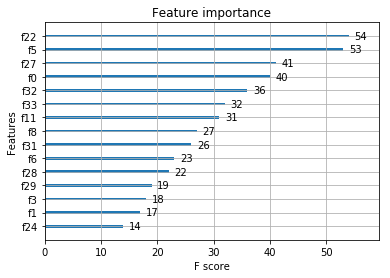

In [217]:
from xgboost import plot_importance

plt.figure(figsize=(20,4))
plot_importance(xgb, max_num_features=15)
plt.show()

In [218]:
X_sub = data[data.in_target.astype(bool)].drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1)
y_sub = data[data.in_target.astype(bool)][['Season', 'team_a', 'team_b', 'a_win', 'in_target']]

xgb = XGBClassifier()
xgb.fit(X.values, y.values.reshape(-1))
preds = xgb.predict_proba(X_sub.values)

sub = cp.deepcopy(y_sub)
sub['Pred'] = preds[:,1]
sub['ID'] = sub['Season'].map(str) + '_' + sub['team_a'].map(str) + '_' + sub['team_b'].map(str)
sub.set_index('ID', inplace=True)
sub.drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1, inplace=True)
sub.head()

,Pred
ID,
2014_1107_1110,0.611611
2014_1107_1112,0.021496
2014_1107_1113,0.874790
2014_1107_1124,0.069156
2014_1107_1140,0.900930


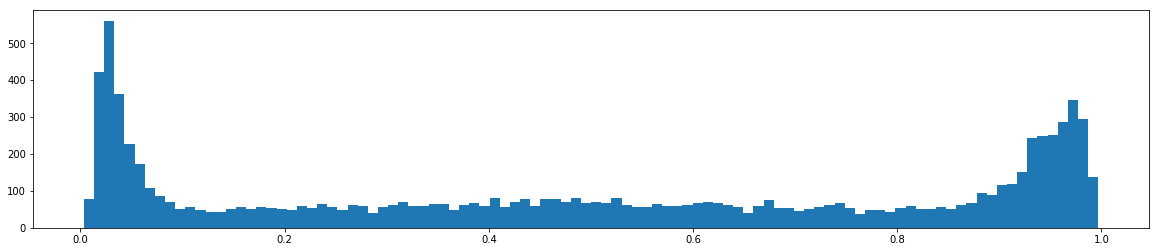

In [219]:
plt.figure(figsize=(20,4))
plt.hist(sub['Pred'], bins=100)
plt.show()

In [220]:
sub.to_csv('submissions/xgb_baseline_2_corrected_lags_and_features.csv')